In [1]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5 statsmodels rich
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from rich.progress import track

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


In [2]:
lcpm = (
    pl.read_csv(
        "../results/lcpm.tsv",
        separator="\t",
    )
    .rename({"gene": "gene_id"})
    .group_by("gene_id")
    .agg(pl.col("lcpm").mean().alias("lcpm"))
)

From that Zhang paper, looks like I should be calculating methylation across exons, as transposable element inserts can mess up mean methylation values.

In [3]:
cg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict=False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CG").alias("type"),
    )
)

chg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHG").alias("type"),
    )
)

chh_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHH.gff",
        has_header=False,
        separator="\t",
    )
    # Need to account for Helixer gene ids (really wish I fixed this earlier)
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHH").alias("type"),
    )
)

methylation = pl.concat([cg_methylation, chg_methylation, chh_methylation])

# Get average exon methylation per gene
subfeature_methylation = (
    methylation
    # Filter out non-exon/intron features
    .filter(pl.col("column_3").str.contains("exon|intron"))
    .groupby(["gene", "column_3", "type"])
    # Calculate the mean methylation of feature for each gene
    .agg(
        (pl.col("weighted_mean").sum() / pl.col("column_11").sum()).alias("weighted_mean")
    )
    # Pivot so methylation is in columns
    .pivot(index=["gene", "column_3"], columns="type", values="weighted_mean") 
    # Classify genes according as UM, gbM, teM, or ambiguous
    # UM = CG <= 0.05, CHG <= 0.05
    # gbM = CG > 0.2, CHG <=0.05
    # teM = CG > 0.4, CHG > 0.4
    .with_columns(
        (
            pl
            .when((pl.col("CG") <= 0.05) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("UM"))
            .when((pl.col("CG") > 0.2) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("gbM"))
            .when((pl.col("CG") > 0.4) & (pl.col("CHG") > 0.4))
            .then(pl.lit("teM"))
            .otherwise(pl.lit("ambiguous"))
        ).alias("classification")
    )
)

subfeature_methylation.write_csv("../results/subfeature_methylation.csv")

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_8150/2581538231.py:63: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["gene", "column_3", "type"])


How many genes belong to each classification?

In [4]:
(
    subfeature_methylation
    .filter(pl.col("column_3") == "exon")
    .group_by("classification")
    .agg(pl.count("gene").alias("n_genes"))
)

classification,n_genes
str,u32
"""teM""",8076
"""ambiguous""",7957
"""UM""",5940
"""gbM""",17151


Plot the distributions for exons and introns

<Figure size 3540x1800 with 0 Axes>

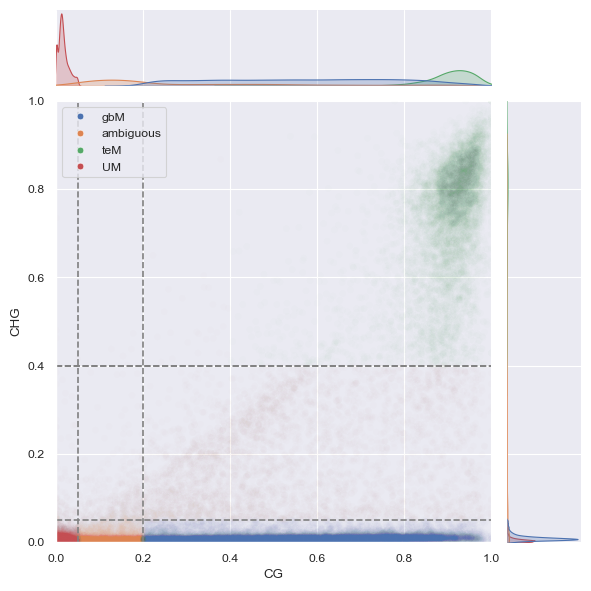

In [9]:
plt.figure(figsize=(5.9, 3), dpi=600)
methylation_scatter = sns.jointplot(
    (
        subfeature_methylation
        .filter(pl.col("column_3") == "exon")
    ),
    x="CG",
    y="CHG",
    hue="classification",
    alpha=0.01,
    xlim=(0, 1),
    ylim=(0, 1),
)

# Need to plot some guides for the cutoffs
plt.axvline(0.05, color="grey", linestyle="--")
plt.axhline(0.05, color="grey", linestyle="--")
plt.axvline(0.2, color="grey", linestyle="--")
plt.axhline(0.4, color="grey", linestyle="--")
plt.axhline(0.4, color="grey", linestyle="--")

# omg matplotlib why is this the way to fix alpha values
for lh in plt.legend().legend_handles:
    lh.set_alpha(1)

plt.savefig("../../pandoc-thesis/figures/methylation_scatterplot.png")

Aight fam lets check the tpm levels

certified lover boy certifed WAP WAP WAP WAP

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_8150/1218698157.py:11: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lcpm


                            OLS Regression Results                            
Dep. Variable:                log_tpm   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                 7.088e+04
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:04:26   Log-Likelihood:            -6.9464e+05
No. Observations:              472728   AIC:                         1.389e+06
Df Residuals:                  472724   BIC:                         1.389e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

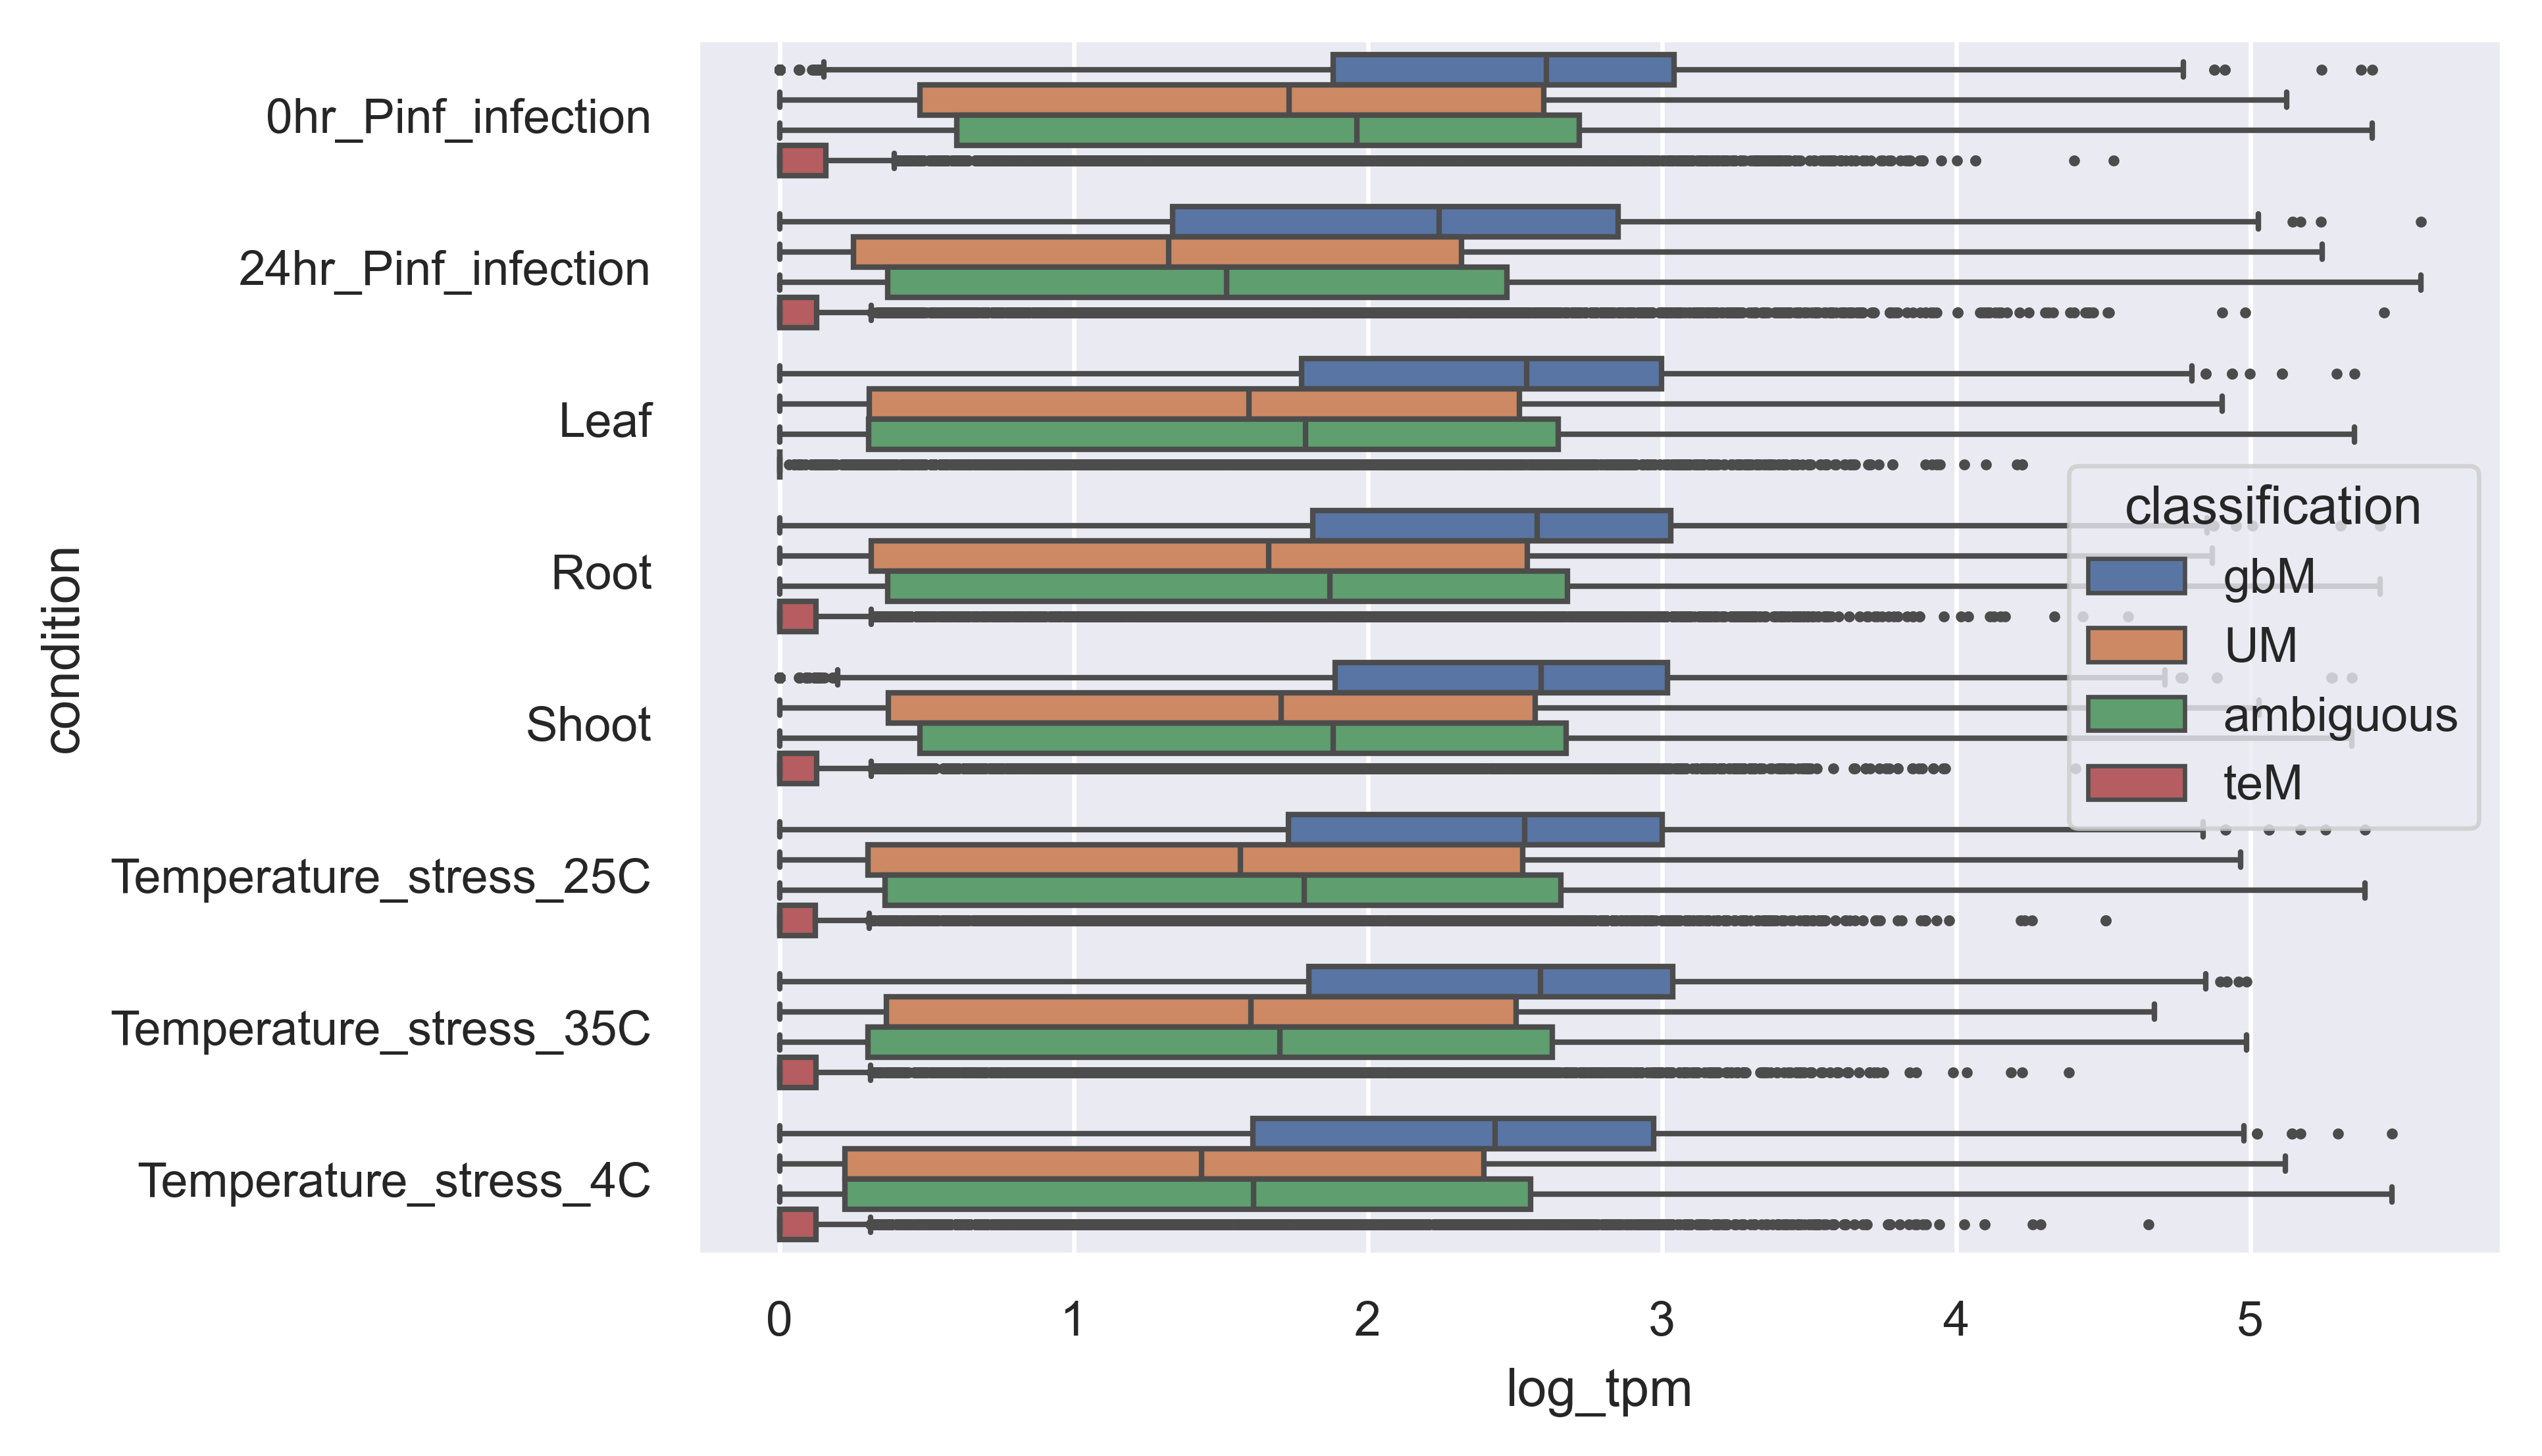

Classify genes as being either tissue expressed on constitutively

In [34]:
def classify_expression(list_of_tpm):
    expressed_count, unexpressed_count = 0, 0
    for tpm in list_of_tpm:
        if tpm >= 1:
            expressed_count += 1
        else:
            unexpressed_count += 1
    if expressed_count == len(list_of_tpm):
        return "constitutive"
    if expressed_count == 0:
        return "silent"
    if expressed_count >= 1 & unexpressed_count >= 0:
        return "tissue_specific"

(
    lcpm
    .filter(pl.col("condition").str.contains("Leaf|Root|Shoot"))
    # Classify as tissue specific if log_tpm > 1 in one tissue, constituive if log_tpm > 1 in all tissues
    .group_by("gene")
    .agg(pl.col("tpm"))
    .with_columns(
        pl.col("tpm").map_elements(classify_expression).alias("expression")
    )
    .group_by("expression")
    .agg(pl.count("gene").alias("n_genes"))
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_8150/2967484339.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


expression,n_genes
str,u32
"""constitutive""",22127
"""silent""",9787
"""tissue_specific""",3872
